## Notes

### Targets
- 5 km tempo på $s$ < 4:25 min/km.
- 10 km distance på $s$ < 4:50 min/km.
- 15 km distance på $s$ < 5:25 min/km.

### Distance training strategy
- Pick a 5 km interval (from 3 to 8 km for example) where I run 5:00 min/km, then use my natural form pace for the rest. 

### Strength
- Begin training deadlift and squats for core conditioning.
- Plank and new types of planks.
- Trap bar exercises? (Alternative deadlift.)
- Hanging pull-ups: practice hanging for 15 seconds and small pull-ups that only completes the first part of the full pull-up movement.

### Battles
- Start eating a small breakfast to avoid hunger when fasting over midday and afternoon.
- Drink more water during the day. Make it a habit to fill up a water bottle with fresh, cold water instead of getting a protein drink. 
- Drink only two bottles of protein drink at work. 
- Drink only 1-2 cups of coffee in the evening.
- Train leg strength on/around 5 km runs.

### VO2 Max
Start doing VO2 max training 1 time per week. Hit 90-100% of maximum heart rate.
- Mountain march/run on treadmill: increase incline by 2% every 5 minutes.
- 4 sets of 800 meter sprints outside.
- Hill running: run up Frederikberg Slots bakke, jog down, then run up again - about 8 times.
- Race to the finish line: finish off the last 500 m of a run with higher and higher pace.

### Food
- Include more healthy fats. Eat honey with oatmeals on days near a 20 km run.
- Healthy fats: almonds.

### To do


In [1]:
import calendar
from scipy.optimize import curve_fit
from scipy.stats import linregress 
import statsmodels.api as sm 
import datetime
import matplotlib.dates as pltdates
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from matplotlib.ticker import MaxNLocator

In [2]:
# Træningsvariabler 
vægt = 65
alder = 33
# Løb 
løb_1km = vægt*4.7 # Konstanten er estimeret kJ brugt på løb 5-6 min/km.  
# Energi i 1 kg kropsvægt
energi_vægt = 32_200 # kJ/kg
# Styrketræning
styrke_1min = 18 # kJ forbrændt på 1 minut i styrketræning
# Konversion fra kcal til kJ:
kcal_kj = 4.184

In [3]:
# Tid og perioder 
first_day = datetime.date(2022, 8, 22)
today = datetime.date.today()
current_month = datetime.date.today().month
current_year = datetime.date.today().year 
period_delta = today - first_day 
period_days = period_delta.days
period_months = period_days/(365/12)

df = pd.read_csv('training_data.csv', sep=',')

# Gør tid til datetime midlertidigt. 
df['tid'] = pd.to_datetime(df['tid'], format='%H:%M:%S')

# Beregn tid i minutter som float. 
df['t float'] = df['tid'].dt.hour * 60 + df['tid'].dt.minute + df['tid'].dt.second / 60

# Formater tid tilbage til string.
df['tid'] = df['tid'].dt.strftime('%H:%M:%S')

# Formater datokolonne. 
df['dato'] = pd.to_datetime(df['dato'], format='%d-%m-%Y')

# Sorter data.
df = df.sort_values(by="dato", ascending=False)

# Konverter km til numeriske værdier og X til NaN. 
df['km'] = pd.to_numeric(df['km'], errors='coerce')

# Lav kolonne med forbrændt kJ.
df['kj'] = df.apply(lambda row: row['km'] * løb_1km if row['navn'] == 'Løb' else row['t float'] * styrke_1min, axis=1)

# Lav kolonne med min/km for løb.
df['min/km'] = df.apply(lambda row: row['t float'] / row['km'] if row['navn'] == 'Løb' else 0, axis=1)
df['tempo'] = pd.to_datetime(df['min/km'], unit='m').dt.strftime('%H:%M:%S')

# Arranger vigtigste kategorier først.
df = df[["navn", "dato", 'kategori', "km", "min/km", "tempo", "tid", "HR", "kj", "lokation", "præcis tid", "t float"]]

# Slet heart rate observationer før 30-10-2024, fordi de er falske. 
df.loc[df["dato"] < "30-10-2024", "HR"] = np.nan 

In [4]:
RHR = 60
MHR = 220 - alder
HRR = MHR - RHR
print(f'Maximum heart rate (theoretical): {MHR}')

max_obs_MHR = 177
print(f'Maximum heart rate (observed): {max_obs_MHR}')

z2 = (MHR*0.6, MHR*0.7)
print(f'Zone 2: {z2}')
t2 = RHR + (0.7 * HRR)
print(f'Threshold 2: {round(t2)}')

z3 = (MHR *0.7, MHR * 0.8)
print(f'Zone 3: {z3}')

t3 = RHR + (0.8 * HRR)
print(f'Threshold 3: {round(t3)}')

Maximum heart rate (theoretical): 187
Maximum heart rate (observed): 177
Zone 2: (112.2, 130.9)
Threshold 2: 149
Zone 3: (130.9, 149.6)
Threshold 3: 162


In [5]:
# Dataframe til løb.
df_løb = df[df['navn'] == 'Løb'].copy()
# Dataframe til styrketræning.
df_styrke = df[df['navn'] == 'Træning'].copy()

df_løb['km'] = df_løb['km'].astype(float) # Formater km. 
df_løb.set_index('dato', inplace=True) # Sæt dato som index.
cmlative_km = df_løb.resample('M')['km'].sum() # Gruppér efter måned og beregn summer.
cmlative_km = cmlative_km.reset_index() # Reset index for at få dato som kolonne igen.
df_løb = df_løb.reset_index() 

# Dataframe til plot
cmlative_km_plt = cmlative_km[-12:]

cmlative_km_record = cmlative_km.copy()
cmlative_km_record = cmlative_km_record.sort_values(by='km', ascending=False)
cmlative_km_record['place'] = np.arange(1, len(cmlative_km_record) + 1) # Tilføj kolonne med placering.

# Dataframe til styrketræning 
df_styrke['t float'] = df_styrke['t float'].astype(float) # Formater tid. 
df_styrke.set_index('dato', inplace=True) # Sæt dato som index.

cmlative_str = df_styrke.resample('M')['t float'].cumsum() # Gruppér efter måned og beregn summer.
# Reset index for at få dato som kolonne igen.
cmlative_str = cmlative_str.reset_index()[-80:] # Medtag kun de seneste 80 rækker. 

# Gennemsnit km/måned
avg_km_måned = cmlative_km_plt['km'][0:-1].sum() / 11

# Dataframe for løb med præcis tid og uden Reconstitution eller Distance. 
df_løb_spd = df_løb.copy()
df_løb_spd = df_løb_spd[
                        (df_løb_spd['kategori'] == 'Tempo')
                        & (df_løb_spd['min/km'] != 0) 
                        & (df_løb_spd['præcis tid'] == 'Y') 
                        & (df_løb_spd['km'] < 8) 
                        ]
# Kun tempotræning på distance under 8 km. 

df_løb_recon = df_løb.copy()
df_løb_recon = df_løb_recon[df_løb_recon['kategori'] == 'Reconstitution']

# Dataframe for distance med præcis tid. 
df_løb_dist = df_løb.copy()
df_løb_dist = df_løb_dist[(df_løb_dist['kategori'] == 'Distance') & (df_løb_dist['præcis tid'] == 'Y') 
    & (df_løb_dist['min/km'] != 0)]

# Dataframe til ugedistancer.
df_løb['km'] = df_løb['km'].astype(float) # Formater km. 
df_løb.set_index('dato', inplace=True) # Sæt dato som index.
uge_løb_df = df_løb.resample('W', closed="right")['km'].sum() # Gruppér efter måned og beregn summer.
uge_løb_df = uge_løb_df.reset_index() # Reset index for at få dato som kolonne igen.
df_løb = df_løb.reset_index()

uge_løb_df = uge_løb_df[-8:].sort_values(by='dato', ascending=False)

In [6]:
# Projektion for hvad jeg vil løbe resten af måneden.
first_day_proj = today.replace(day=1)
remaining_days = datetime.date(current_year, current_month\
    , calendar.monthrange(current_year, current_month)[1]) - today

def month_distance_projection():
    default_proj = avg_km_måned
        
    sum_proj = cmlative_km_plt.iloc[-1][1]
    days_delta_proj = today - first_day_proj + datetime.timedelta(days=1)
        
    # Udregn projektionen baseret på gennemsnittet denne måned
    month_projection = sum_proj + (int(sum_proj) / int(days_delta_proj.days)) * int(remaining_days.days)

    if cmlative_km_plt.iloc[-1][0].month != current_month:
    # if sum_proj < 1:
        return default_proj

    else: 
        return month_projection


## Alt træning

In [7]:
df.iloc[0:14,:]

,navn,dato,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
367,Træning,2024-12-31,Free,NaN,0.000000,00:00:00,00:50:00,NaN,900.000,Visma House,y,50.000000
366,Løb,2024-12-29,Distance,15.01,5.661781,00:05:39,01:24:59,145,4585.555,Frederiksberg Have,Y,84.983333
365,Træning,2024-12-28,Free,NaN,0.000000,00:00:00,00:45:00,NaN,810.000,Visma House,Y,45.000000
364,Løb,2024-12-28,Free,5.40,5.503086,00:05:30,00:29:43,154,1649.700,Frederiksberg Have,Y,29.716667
363,Træning,2024-12-22,Free,NaN,0.000000,00:00:00,00:45:00,NaN,810.000,Visma House,Y,45.000000
362,Løb,2024-12-22,Tempo,5.35,5.112150,00:05:06,00:27:21,153,1634.425,Frederiksberg Have,Y,27.350000
361,Træning,2024-12-21,Free,NaN,0.000000,00:00:00,00:45:00,NaN,810.000,Visma House,Y,45.000000
360,Løb,2024-12-20,Free,16.02,6.070537,00:06:04,01:37:15,146,4894.110,Frederiksberg Have,Y,97.250000
359,Træning,2024-12-19,Free,NaN,0.000000,00:00:00,00:40:00,,720.000,Visma House,Y,40.000000
358,Træning,2024-12-14,Free,NaN,0.000000,00:00:00,00:40:00,NaN,720.000,Visma House,Y,40.000000


## Alt løb

In [8]:
df_løb.sort_values(by="dato", ascending=False)[0:15]

,dato,navn,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
0,2024-12-29,Løb,Distance,15.01,5.661781,00:05:39,01:24:59,145,4585.555,Frederiksberg Have,Y,84.983333
1,2024-12-28,Løb,Free,5.40,5.503086,00:05:30,00:29:43,154,1649.700,Frederiksberg Have,Y,29.716667
2,2024-12-22,Løb,Tempo,5.35,5.112150,00:05:06,00:27:21,153,1634.425,Frederiksberg Have,Y,27.350000
3,2024-12-20,Løb,Free,16.02,6.070537,00:06:04,01:37:15,146,4894.110,Frederiksberg Have,Y,97.250000
4,2024-12-10,Løb,Reconstitution,5.76,5.601852,00:05:36,00:32:16,157,1759.680,Frederiksberg Have,Y,32.266667
5,2024-12-08,Løb,Distance,10.01,5.572761,00:05:34,00:55:47,161,3058.055,Frederiksberg Have,Y,55.783333
6,2024-12-07,Løb,Reconstitution,6.03,5.279160,00:05:16,00:31:50,156,1842.165,Frederiksberg Have,Y,31.833333
7,2024-11-30,Løb,Distance,12.41,5.821918,00:05:49,01:12:15,156,3791.255,Frederiksberg Have,Y,72.250000
8,2024-11-17,Løb,Distance,15.01,5.569620,00:05:34,01:23:36,148,4585.555,Frederiksberg Have,Y,83.600000
9,2024-11-15,Løb,Distance,15.00,5.552222,00:05:33,01:23:17,147,4582.500,Frederiksberg Have,Y,83.283333


## Ugedistancer

In [9]:
uge_løb_df

,dato,km
380,2024-12-29,20.41
379,2024-12-22,21.37
378,2024-12-15,5.76
377,2024-12-08,16.04
376,2024-12-01,12.41
375,2024-11-24,0.00
374,2024-11-17,30.01
373,2024-11-10,35.01


## Kilometer på et år

In [10]:
df_år_løb = df_løb[df_løb["dato"].dt.year == 2024]
år_total = df_år_løb["km"].cumsum()
print("Kilometer i 2024: ", round(år_total.values[-1], 1))
df_år_løb = df_løb[df_løb["dato"].dt.year == current_year]
år_total = df_år_løb["km"].cumsum()
print("Kilometer i år: ", round(år_total.values[-1], 1))

Kilometer i 2024:  864.3
Kilometer i år:  864.3


## Distance: kronologisk

In [11]:
df_løb_dist[:10].sort_values(by="dato", ascending=False)

,dato,navn,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
0,2024-12-29,Løb,Distance,15.01,5.661781,00:05:39,01:24:59,145,4585.555,Frederiksberg Have,Y,84.983333
5,2024-12-08,Løb,Distance,10.01,5.572761,00:05:34,00:55:47,161,3058.055,Frederiksberg Have,Y,55.783333
7,2024-11-30,Løb,Distance,12.41,5.821918,00:05:49,01:12:15,156,3791.255,Frederiksberg Have,Y,72.250000
8,2024-11-17,Løb,Distance,15.01,5.569620,00:05:34,01:23:36,148,4585.555,Frederiksberg Have,Y,83.600000
9,2024-11-15,Løb,Distance,15.00,5.552222,00:05:33,01:23:17,147,4582.500,Frederiksberg Have,Y,83.283333
10,2024-11-09,Løb,Distance,25.00,5.774667,00:05:46,02:24:22,150,7637.500,Frederiksberg Have,Y,144.366667
11,2024-11-05,Løb,Distance,10.01,5.103230,00:05:06,00:51:05,157,3058.055,Frederiksberg,Y,51.083333
13,2024-10-30,Løb,Distance,10.00,5.125000,00:05:07,00:51:15,155,3055.000,Frederiksberg Have,Y,51.250000
16,2024-10-22,Løb,Distance,8.01,5.416146,00:05:24,00:43:23,NaN,2447.055,Frederiksberg Have,Y,43.383333
20,2024-10-18,Løb,Distance,9.01,5.445801,00:05:26,00:49:04,NaN,2752.555,Frederiksberg Have,Y,49.066667


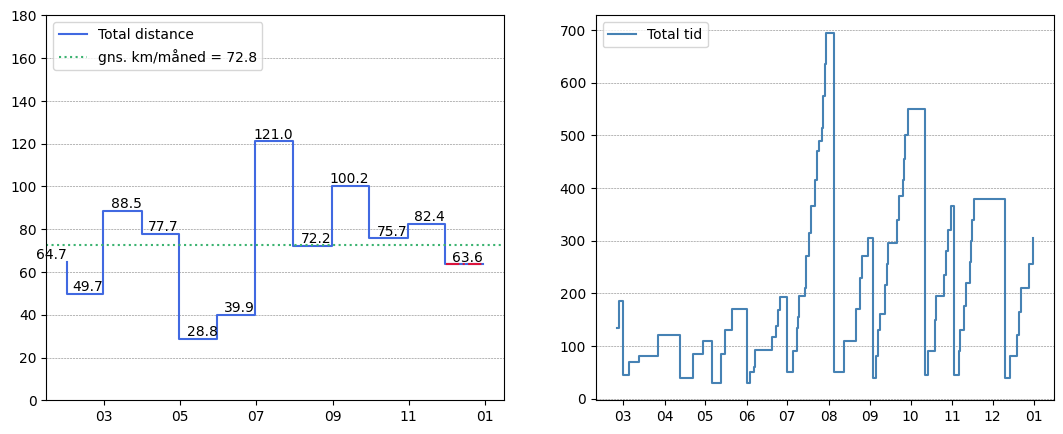

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5))

# LØB 
# Plot månedssummer. 
ax[0].plot(cmlative_km_plt['dato'], cmlative_km_plt['km'], color='royalblue', drawstyle='steps-pre', label='Total distance')

# Tilføj km-værdier. 
for x, y in zip(cmlative_km_plt['dato'], cmlative_km_plt['km']):
    ax[0].text(x, y, str(round(y,1)), horizontalalignment='right', verticalalignment="bottom", fontsize="medium")

# Linje til gennemsnit. 
ax[0].axhline(avg_km_måned, color='mediumseagreen', linestyle=':', label=f'gns. km/måned = {round(avg_km_måned, 1)}')


# Plot fremskrivning af løbedistance for denne måned baseret på km løbet indtil nu.
ax[0].hlines(month_distance_projection(), pltdates.date2num(first_day_proj), pltdates.date2num(today+remaining_days), 
    color='crimson', linestyle='-.')

# STYRKE 
ax[1].plot(cmlative_str['dato'], cmlative_str['t float'], color='steelblue', drawstyle='steps-post', label='Total tid')

# GENERELT 
ax[0].grid(True, axis='y', linestyle='--', linewidth=0.4, color='gray')
ax[1].grid(True, axis='y', linestyle='--', linewidth=0.4, color='gray')
ax[0].set_ylim(0,180)
date_format_løb = pltdates.DateFormatter('%m')
ax[0].xaxis.set_major_formatter(date_format_løb)
ax[1].xaxis.set_major_formatter(date_format_løb)
ax[1].legend(loc='upper left')
ax[0].legend(loc='upper left')
plt.show()

## Tempo

In [13]:
# Lineær regression for løbehastighed.
x = (df_løb_spd['dato'] - df_løb_spd['dato'].min()).dt.days
y = df_løb_spd['min/km']
a, b, r, p, se = linregress(x, y)

def lin_spd(x):
    return a * x + b

# Multipel lineær regression.
df_løb_mreg = df_løb_spd.copy()
df_løb_mreg['dage'] = ((df_løb_mreg['dato'] - df_løb_mreg['dato'].min()).dt.days).astype(float)

y_MLR = df_løb_mreg['min/km']
X_MLR = df_løb_mreg[['dage', 'km']]

X_MLR = sm.add_constant(X_MLR)

model_MLR = sm.OLS(y, X_MLR).fit()
# print(model_MLR.summary())

def MLR_spd(x):
    return model_MLR.params[0] + model_MLR.params[1] * x
# Leave out km parameter because of insignificance.

# Exponential regression.
def exp_spd(x, alfa, beta, eta):
    return alfa * np.exp(-beta * x) + eta

p_opt, p_cov = curve_fit(exp_spd, x, y)

c:\Users\Lindholm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
# Distance MLR 
# Multipel lineær regression.
df_løb_dist_mreg = df_løb_dist.copy()
df_løb_dist_mreg = df_løb_dist_mreg.iloc[:-2,:]
df_løb_dist_mreg['dage'] = ((df_løb_dist_mreg['dato'] - df_løb_dist_mreg['dato'].min()).dt.days).astype(float)

y_dist_MLR = df_løb_dist_mreg['min/km']
X_dist_MLR = df_løb_dist_mreg[['dage', 'km']]

X_dist_MLR = sm.add_constant(X_dist_MLR)
model_dist_MLR = sm.OLS(y_dist_MLR, X_dist_MLR).fit()
# print(model_dist_MLR.summary())

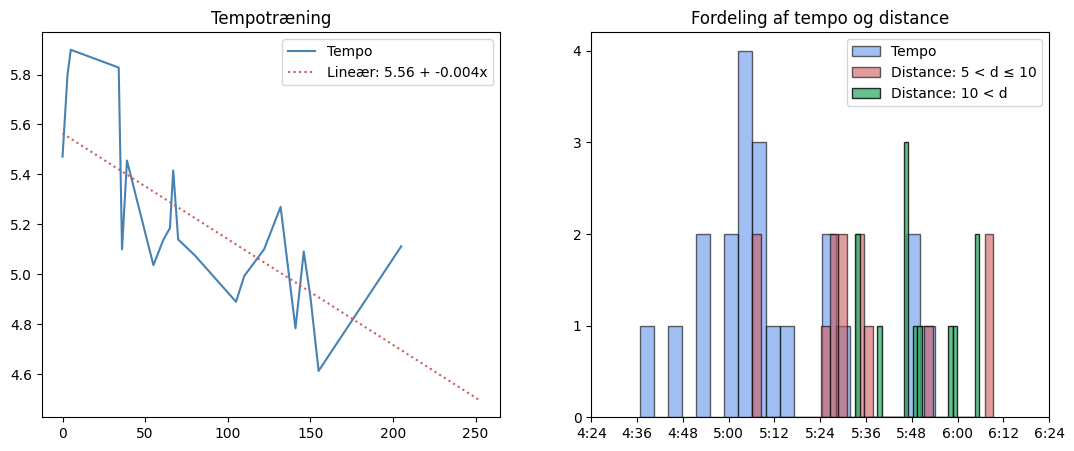

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5))

# Plot for tempo.
ax[0].plot(x, df_løb_spd['min/km'], color='steelblue', label='Tempo')

l = np.linspace(0, df_løb_spd.size, df_løb_spd.size)
# Plot for simpel lineær regression.
ax[0].plot(l, lin_spd(l), color='indianred', linestyle=':', label=f'Lineær: {round(b, 2)} + {round(a, 3)}x')

# Plot for multipel lineær regression.
# ax[0].plot(l, MLR_spd(l), color='crimson', linestyle='-.', label=f'Lineær: {round(model_MLR.params[0], 2)} + {round(model_MLR.params[1], 4)}x')

# Plot for eksponentiel regression.
# ax[0].plot(l, exp_spd(l, *p_opt), color='mediumseagreen', linestyle='--', 
#     label=f'Exponential: {round(p_opt[0], 2)} exp(-{round(p_opt[1], 4)}x) + {round(p_opt[2], 2)}')

# FORDELINGER 
# Fordeling af tempo. 
ax[1].hist(df_løb_spd['min/km'], bins=df_løb_spd.shape[0], color='cornflowerblue', edgecolor='black', label='Tempo', alpha=0.6)
# Fordeling af distance.
df_upto10 = df_løb_dist[(df_løb_dist["km"] <= 10.1) & (df_løb_dist["min/km"] < 6.5)]
df_over10 = df_løb_dist[(df_løb_dist["km"] > 10.1) & (df_løb_dist["min/km"] < 6.5)]
ax[1].hist(df_upto10["min/km"], bins=df_løb_dist.shape[0], color="indianred", edgecolor="black", 
    alpha=0.6, label="Distance: 5 < d \u2264 10")
ax[1].hist(df_over10["min/km"], bins=df_løb_dist.shape[0], color="mediumseagreen", edgecolor="black", 
    alpha=0.8, label="Distance: 10 < d")

ax[0].title.set_text('Tempotræning')
ax[0].legend()
ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].title.set_text('Fordeling af tempo og distance')
ax[1].legend()
# Convert x-axis values to min:sec format. 
orig_ticks = plt.xticks()[0]
x_ticks = [f"{int(x)}:{int((x - int(x)) * 60):02d}" for x in orig_ticks]
plt.xticks(orig_ticks, x_ticks)

plt.show()

### MLR: Tempo

In [16]:
print(f'Tempoforbedring pr. dag (MLR): {round(model_MLR.params[1]*60, 3)} sek/dag')
print(f'Tempoforbedring pr. dag (lineær): {round(a*60, 3)} sek/dag')
print(f"Error = {se:.6f}")
print(f'Tempoforbedring (exp): {round(p_opt[0]*-p_opt[1]*np.exp(-p_opt[1]), 4)}x')

Tempoforbedring pr. dag (MLR): -0.256 sek/dag
Tempoforbedring pr. dag (lineær): -0.254 sek/dag
Error = 0.000943
Tempoforbedring (exp): -0.0136x


In [17]:
trans_løb_spd = df_løb_spd.copy()
trans_løb_spd["log min/km"] = np.log(trans_løb_spd["min/km"]*60)
# plt.scatter(x, trans_løb_spd["log min/km"], color='mediumseagreen', label='log(km/sek)')

y = trans_løb_spd['log min/km']
a2, b2, r2, p2, se2 = linregress(x, y)

def log_lin_spd(x):
    return a2 * x + b2

# plt.plot(x, log_lin_spd(x), label=f"{a2:.5f}x+{b2:.2f}", color="indianred")
print(f"Percentage change in speed every month: {np.exp(a2*(365/12))-1:.4f}")
print(f"Error = {se2:.6f}")

# plt.title("Log linear tempo")
# plt.legend()
# plt.show()

Percentage change in speed every month: -0.0241
Error = 0.000178


### MLR: distance

In [18]:
print("Hastighedsforbedring pr. dag (distanceløb) =", round(model_dist_MLR.params[1]*60, 3), "sek/dag.")
print("Error = ", round(model_dist_MLR.bse[0], 3))

Hastighedsforbedring pr. dag (distanceløb) = -0.369 sek/dag.
Error =  0.177


## Tempoløb: kronologisk

In [19]:
df_løb_spd[:10].sort_values(by="dato", ascending=False)

,dato,navn,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
2,2024-12-22,Løb,Tempo,5.35,5.112150,00:05:06,00:27:21,153,1634.425,Frederiksberg Have,Y,27.350000
12,2024-11-02,Løb,Tempo,5.00,4.613333,00:04:36,00:23:04,165,1527.500,Frederiksberg Have,Y,23.066667
14,2024-10-28,Løb,Tempo,5.28,4.911616,00:04:54,00:25:56,NaN,1613.040,Frederiksberg Have,Y,25.933333
15,2024-10-24,Løb,Tempo,4.19,5.091488,00:05:05,00:21:20,NaN,1280.045,Søndermarken,Y,21.333333
19,2024-10-19,Løb,Tempo,5.01,4.783766,00:04:47,00:23:58,NaN,1530.555,Søndermarken,Y,23.966667
23,2024-10-10,Løb,Tempo,5.00,5.270000,00:05:16,00:26:21,NaN,1527.500,Frederiksberg Have,Y,26.350000
25,2024-09-30,Løb,Tempo,7.51,5.099867,00:05:05,00:38:18,NaN,2294.305,Søndermarken,Y,38.300000
33,2024-09-18,Løb,Tempo,5.01,4.993347,00:04:59,00:25:01,NaN,1530.555,Søndermarken,Y,25.016667
35,2024-09-13,Løb,Tempo,5.01,4.890220,00:04:53,00:24:30,NaN,1530.555,Søndermarken,Y,24.500000
43,2024-08-19,Løb,Tempo,5.01,5.076514,00:05:04,00:25:26,NaN,1530.555,Søndermarken,Y,25.433333


## Hurtigste tempoløb

In [20]:
df_løb_spd["rank"] = df_løb_spd["min/km"].sort_values(ascending=False).rank(method="first").astype(int)
cols = ["rank"] + [col for col in df_løb_spd.columns if col != 'rank']
df_løb_spd.sort_values(by="min/km", ascending=True)[0:10][cols]


,rank,dato,navn,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
12,1,2024-11-02,Løb,Tempo,5.00,4.613333,00:04:36,00:23:04,165,1527.500,Frederiksberg Have,Y,23.066667
19,2,2024-10-19,Løb,Tempo,5.01,4.783766,00:04:47,00:23:58,NaN,1530.555,Søndermarken,Y,23.966667
35,3,2024-09-13,Løb,Tempo,5.01,4.890220,00:04:53,00:24:30,NaN,1530.555,Søndermarken,Y,24.500000
14,4,2024-10-28,Løb,Tempo,5.28,4.911616,00:04:54,00:25:56,NaN,1613.040,Frederiksberg Have,Y,25.933333
33,5,2024-09-18,Løb,Tempo,5.01,4.993347,00:04:59,00:25:01,NaN,1530.555,Søndermarken,Y,25.016667
55,6,2024-07-25,Løb,Tempo,5.00,5.036667,00:05:02,00:25:11,NaN,1527.500,Søndermarken,Y,25.183333
43,7,2024-08-19,Løb,Tempo,5.01,5.076514,00:05:04,00:25:26,NaN,1530.555,Søndermarken,Y,25.433333
15,8,2024-10-24,Løb,Tempo,4.19,5.091488,00:05:05,00:21:20,NaN,1280.045,Søndermarken,Y,21.333333
68,9,2024-07-06,Løb,Tempo,3.84,5.099826,00:05:05,00:19:35,NaN,1173.120,Søndermarken,Y,19.583333
25,10,2024-09-30,Løb,Tempo,7.51,5.099867,00:05:05,00:38:18,NaN,2294.305,Søndermarken,Y,38.300000


## Hurtigste distanceløb

In [21]:
df_løb_dist["rank"] = df_løb_dist["min/km"].sort_values(ascending=False).rank(method="first").astype(int)
cols = ["rank"] + [col for col in df_løb_dist.columns if col != 'rank']
df_løb_dist.sort_values(by="min/km", ascending=True)[0:10][cols]

,rank,dato,navn,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
11,1,2024-11-05,Løb,Distance,10.01,5.103230,00:05:06,00:51:05,157,3058.055,Frederiksberg,Y,51.083333
13,2,2024-10-30,Løb,Distance,10.00,5.125000,00:05:07,00:51:15,155,3055.000,Frederiksberg Have,Y,51.250000
16,3,2024-10-22,Løb,Distance,8.01,5.416146,00:05:24,00:43:23,NaN,2447.055,Frederiksberg Have,Y,43.383333
20,4,2024-10-18,Løb,Distance,9.01,5.445801,00:05:26,00:49:04,NaN,2752.555,Frederiksberg Have,Y,49.066667
28,5,2024-09-22,Løb,Distance,10.00,5.458333,00:05:27,00:54:35,NaN,3055.000,Frederiksberg Have,Y,54.583333
81,6,2024-05-20,Løb,Distance,10.00,5.510000,00:05:30,00:55:06,NaN,3055.000,Royal Run København,Y,55.100000
36,7,2024-09-12,Løb,Distance,8.10,5.514403,00:05:30,00:44:40,NaN,2474.550,Frederiksberg Have,Y,44.666667
9,8,2024-11-15,Løb,Distance,15.00,5.552222,00:05:33,01:23:17,147,4582.500,Frederiksberg Have,Y,83.283333
8,9,2024-11-17,Løb,Distance,15.01,5.569620,00:05:34,01:23:36,148,4585.555,Frederiksberg Have,Y,83.600000
5,10,2024-12-08,Løb,Distance,10.01,5.572761,00:05:34,00:55:47,161,3058.055,Frederiksberg Have,Y,55.783333


## Hurtigst maratontræning

In [22]:
df_løb_dist[df_løb_dist["km"] >= 15].sort_values(by="min/km")

,dato,navn,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float,rank
9,2024-11-15,Løb,Distance,15.000,5.552222,00:05:33,01:23:17,147,4582.5000,Frederiksberg Have,Y,83.283333,8
8,2024-11-17,Løb,Distance,15.010,5.569620,00:05:34,01:23:36,148,4585.5550,Frederiksberg Have,Y,83.600000,9
0,2024-12-29,Løb,Distance,15.010,5.661781,00:05:39,01:24:59,145,4585.5550,Frederiksberg Have,Y,84.983333,13
10,2024-11-09,Løb,Distance,25.000,5.774667,00:05:46,02:24:22,150,7637.5000,Frederiksberg Have,Y,144.366667,14
26,2024-09-28,Løb,Distance,20.000,5.780833,00:05:46,01:55:37,NaN,6110.0000,Frederiksberg Have,Y,115.616667,15
219,2017-09-15,Løb,Distance,21.097,5.970833,00:05:58,02:05:58,NaN,6445.1335,CPH Half,Y,125.966667,20
42,2024-08-24,Løb,Distance,17.560,5.993736,00:05:59,01:45:15,NaN,5364.5800,Frederiksberg Have,Y,105.250000,21
46,2024-08-10,Løb,Distance,15.010,6.093715,00:06:05,01:31:28,NaN,4585.5550,Frederiksberg Have,Y,91.466667,23


## Metabolisme

In [23]:
# Mifflin-St Jeor euqation for BMR with physical activity multiplier. 
metab = (10*vægt + 6.25*174 - 5*alder + 5) * kcal_kj * 1.2 # Slightly underestimated PAM.

df_metab = df.copy()

df_metab = df_metab[:150]
df_metab = df_metab.sort_values(by="dato", ascending=True)

# Calculate mean kJ before removing older months.
kj_mean_training = df_metab.describe()['kj'][1]

df_metab1 = df_metab[(df_metab['dato'].dt.year == current_year) & (df_metab['dato'].dt.month == current_month)]

df_metab1 = df_metab1.groupby('dato', as_index=False).agg({'kj': 'sum'})

# Create rows for missing date entries.
# date_range = pd.date_range(start=f"{current_year}-{current_month-1}-01", end=f"{current_year}-{current_month}-{df_metab['dato'].dt.days_in_month.max()}")
# Automatically loading the the maximum number of days in the month stopped worker.
date_range = pd.date_range(start=f"{current_year}-{current_month}-01", end=f"{current_year}-{current_month}-30")

# Drop duplicates.
# df_metab = df_metab.drop_duplicates(subset='dato')
# Reindex the DataFrame to include all dates.
df_metab1 = df_metab1.set_index('dato').reindex(date_range).fillna(0).rename_axis('dato').reset_index()

df_metab1['metab_A'] = metab

df_metab1['shifted_dato'] = df_metab1['dato'].shift(1)
df_metab1['metab_B'] = df_metab1.apply(lambda row: 0 if row['dato'] == row['shifted_dato'] else row['metab_A'], axis=1)
df_metab1['energi'] = df_metab1['metab_B'] + df_metab1['kj']

df_metab1['cmlative m'] = df_metab1['metab_B'].cumsum()
df_metab1['cmlative e'] = df_metab1['energi'].cumsum()

# Physical acitivity energy as % of total energy (both BMR and physical activity).
df_metab1['pct'] = (df_metab1['cmlative e'] - df_metab1['cmlative m']) / df_metab1['cmlative e'] * 100

# ================================================================================================================
# Dataframe for previous month.
df_metab2 = df_metab[(df_metab['dato'].dt.year == current_year) & (df_metab['dato'].dt.month == current_month -1)]

df_metab2 = df_metab2.groupby('dato', as_index=False).agg({'kj': 'sum'})

# Create rows for missing date entries.
# date_range = pd.date_range(start=f"{current_year}-{current_month-1}-01", end=f"{current_year}-{current_month}-{df_metab['dato'].dt.days_in_month.max()}")
# Automatically loading the the maximum number of days in the month stopped working.
date_range = pd.date_range(start=f"{current_year}-{current_month-1}-01", end=f"{current_year}-{current_month-1}-30")

# Drop duplicates.
# df_metab = df_metab.drop_duplicates(subset='dato')
# Reindex the DataFrame to include all dates.
df_metab2 = df_metab2.set_index('dato').reindex(date_range).fillna(0).rename_axis('dato').reset_index()

df_metab2['metab_A'] = metab

df_metab2['shifted_dato'] = df_metab2['dato'].shift(1)
df_metab2['metab_B'] = df_metab2.apply(lambda row: 0 if row['dato'] == row['shifted_dato'] else row['metab_A'], axis=1)
df_metab2['energi'] = df_metab2['metab_B'] + df_metab2['kj']

df_metab2['cmlative m'] = df_metab2['metab_B'].cumsum()
df_metab2['cmlative e'] = df_metab2['energi'].cumsum()

# Physical acitivity energy as % of total energy (both BMR and physical activity).
df_metab2['pct'] = (df_metab2['cmlative e'] - df_metab2['cmlative m']) / df_metab2['cmlative e'] * 100

In [24]:
print("Metabolism =", round(metab))
print('Mean kJ from training =', round(kj_mean_training))
print('Total mean energy per day =', round(metab + kj_mean_training))

Metabolism = 7920
Mean kJ from training = 1484
Total mean energy per day = 9405


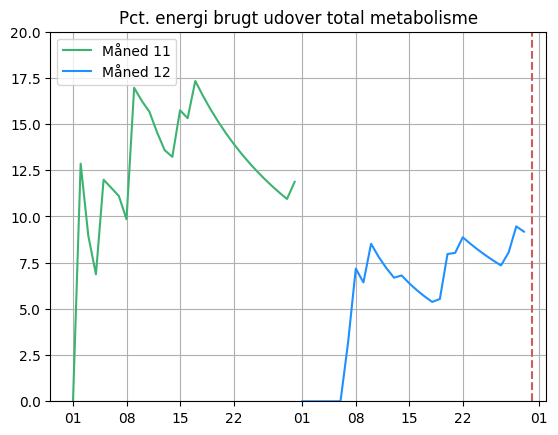

In [25]:
# Filter the DataFrame for the previous and current months.
current_month_data = df_metab1
previous_month_data = df_metab2

fig, ax = plt.subplots()

ax.plot(previous_month_data['dato'], previous_month_data['pct'], color="mediumseagreen", label=f"Måned {current_month - 1}")
ax.plot(current_month_data['dato'], current_month_data['pct'], color='dodgerblue', label=f"Måned {current_month}")

ax.xaxis.set_major_locator(pltdates.AutoDateLocator())
ax.xaxis.set_major_formatter(pltdates.DateFormatter('%d'))

ax.axvline(datetime.date.today(), color="indianred", linestyle="dashed")

ax.set_ylim(0, 20)
plt.grid()
plt.title('Pct. energi brugt udover total metabolisme')
plt.legend()
plt.show()

### BMI
- Normalt BMI i interval $(18.5, 24.99)$

In [26]:
h = 174
kg = vægt 
mål = 21 # Mål-BMI

bmi = round(kg/(h/100)**2, 2)
print("BMI =", bmi)

def BMI(h, v):
    return v/(h/100)**2

def BMI_vægt(h, bmi):
    return ((h/100)**2)*bmi

BMI = 21.47


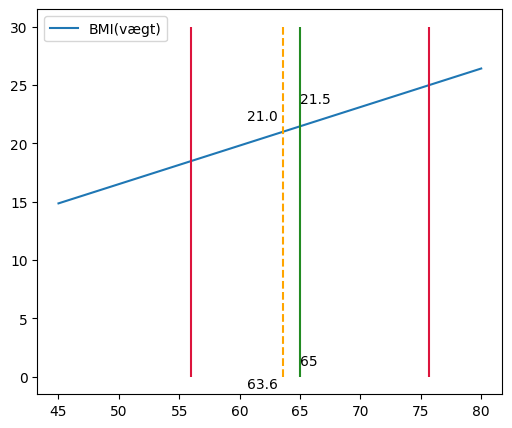

In [27]:
fig_bmi, ax_bmi = plt.subplots(figsize=(6,5))
x_bmi = np.linspace(45,80,200)

ax_bmi.plot(x_bmi, BMI(h, x_bmi), label='BMI(vægt)')
ax_bmi.vlines(BMI_vægt(h, 18.5), 0, 30, color='crimson')
ax_bmi.vlines(BMI_vægt(h, 25), 0, 30, color='crimson')
ax_bmi.vlines(kg, 0, 30, color='forestgreen')
ax_bmi.text(kg, +1, s=kg)
ax_bmi.vlines(BMI_vægt(h, mål), 0, 30, color='orange', linestyles="dashed")
ax_bmi.text(BMI_vægt(h, mål)-3, -1, s=round(BMI_vægt(h, mål),1))

# Tekst til BMI-skæringspunkt. 
ax_bmi.text(kg, BMI(h, vægt)+2, s=round(BMI(h, vægt),1))
ax_bmi.text(BMI_vægt(h, mål)-3, BMI(h, (BMI_vægt(h, mål)))+1, s=round(BMI(h, BMI_vægt(h, mål)),2))
ax_bmi.legend(loc='upper left');